# Neural Network for Binary Classification of Stress
- There will be two classes: Stress and Rest. This is achieved by combining the S1 and S2 class into one class, Stress
- The neural network will only use the two signals from the breathing shirt: Chest Coil Signal and Abdomen Coil Signal.
- This neural network will use CNN layers, max pooling layers and a dense layer at the end before the output layer.

- Class imabalnce addressed by using class weights which improves the recall on the Rest class which sometimes does affectthe recall on the Stress class and therefore accuracy. 
- Tune hyperparamters: TODO

- Could remove S1 class all together? what if people were not too stressed out by trial 1 and it is causing some confusion with the Rest class?
- Could also try spectorgrams and 2d CNN 
- Maybe try adding LSTM layers for memory.


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import scipy.signal
import heartpy as hp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [41]:
# Compilation Options
CLASS_WEIGHTS = True

In [42]:
# Specify the path to your CSV file
file_path = 'filtered_stress_data.csv'

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

# Specify the columns you want to extract
columns_to_extract = ['user_id', 'classification', 'chest_coil', 'abdomen_coil']
features = ['chest_coil', 'abdomen_coil']

# Extract the specified columns
extracted_columns = data[columns_to_extract]

# Drop any rows with missing data
extracted_columns = extracted_columns.dropna()

# Check for non-numeric values in each feature and replace them with NaNs
for feature in features:
    extracted_columns[feature] = pd.to_numeric(extracted_columns[feature], errors='coerce')

# Check if there are any NaNs in the dataset after replacing non-numeric values
if extracted_columns.isnull().values.any():
    print("NaNs detected after attempting to convert non-numeric values to float. Please check the data.")
    # Handle NaNs based on your requirements, such as removing rows with NaNs or imputing missing values
    # For this example, we will remove rows with NaNs
    extracted_columns = extracted_columns.dropna()

# Filter data 
extracted_columns['chest_coil'] = scipy.signal.detrend(extracted_columns['chest_coil'] )
extracted_columns['chest_coil']  = hp.filter_signal(extracted_columns['chest_coil'] , cutoff=1, sample_rate=20.0, filtertype='lowpass', return_top=False)

extracted_columns['abdomen_coil']  = scipy.signal.detrend(extracted_columns['abdomen_coil'] )
extracted_columns['abdomen_coil']  = hp.filter_signal(extracted_columns['abdomen_coil'] , cutoff=1, sample_rate=20.0, filtertype='lowpass', return_top=False)

print(extracted_columns["abdomen_coil"].shape)
print(extracted_columns["chest_coil"].shape)

# Ensure we are using the cleaned data for further processing
data = extracted_columns

# Combine S1 and S2 classes into one "Stress" class
data['classification'] = data['classification'].replace({'S1': 'Stress', 'S2': 'Stress'})

print(data['classification'].value_counts())
print(data['classification'].unique())

(175214,)
(175214,)
classification
Stress    116245
Rest       58969
Name: count, dtype: int64
['Stress' 'Rest']


In [43]:
# Feature Extraction
# Extract features and labels
X = data[['chest_coil', 'abdomen_coil']].values
y = data['classification'].values
user_ids = data['user_id'].values

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(label_encoder.classes_)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data into sequences
time_step_length = 100  # Define your sequence length
num_samples = len(X_scaled) // time_step_length

X_sequences = np.array([X_scaled[i*time_step_length:(i+1)*time_step_length] for i in range(num_samples)])
y_sequences = np.array([y[i*time_step_length] for i in range(num_samples)])
user_id_sequences = np.array([user_ids[i*time_step_length] for i in range(num_samples)])

['Rest' 'Stress']


In [44]:
# Split the data into training and testing sets based on user_id to avoid data leakage
gkf = GroupKFold(n_splits=5)
for train_index, test_index in gkf.split(X_sequences, y_sequences, groups=user_id_sequences):
    X_train, X_test = X_sequences[train_index], X_sequences[test_index]
    y_train, y_test = y_sequences[train_index], y_sequences[test_index]
    break  # Use the first split

# Check the shape of the reshaped data
print(X_train.shape)  # Should be (num_samples, time_step_length, num_features)
print(X_test.shape)

(1384, 100, 2)
(368, 100, 2)


In [45]:
# Compute class weights
if CLASS_WEIGHTS:
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))

In [46]:
# Define the objective function for Optuna
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    num_filters = trial.suggest_int('num_filters', 16, 128, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    
    model = Sequential()
    model.add(Conv1D(num_filters, 3, activation='relu', input_shape=(time_step_length, X_train.shape[2])))
    model.add(MaxPooling1D(2))
    for _ in range(num_layers - 1):
        model.add(Conv1D(num_filters, 3, activation='relu'))
        model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with Adam optimizer and learning rate scheduler
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks for learning rate adjustment and early stopping
    lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    if CLASS_WEIGHTS:
        # Train the model with class weights
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                            class_weight=class_weights_dict, callbacks=[lr_reduction, early_stopping])
    else:
        # Train the model without class weights 
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                        callbacks=[lr_reduction, early_stopping])

    score = model.evaluate(X_test, y_test, verbose=0)

    return score[1]

In [47]:
# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Retrieve best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

[I 2024-05-24 09:27:39,055] A new study created in memory with name: no-name-246f6bf3-21ea-4089-876c-1edcb303faee


Epoch 1/50


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6175 - loss: 0.6498 - val_accuracy: 0.1196 - val_loss: 1.7108 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7050 - loss: 0.5494 - val_accuracy: 0.1304 - val_loss: 1.8127 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7359 - loss: 0.5297 - val_accuracy: 0.1196 - val_loss: 3.1517 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7905 - loss: 0.4556 - val_accuracy: 0.0543 - val_loss: 6.9804 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8108 - loss: 0.3606 - val_accuracy: 0.0625 - val_loss: 8.7683 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8344 - loss: 0.3195 - val_accuracy: 0.1005 - val_loss: 11.3181 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8243 - loss: 0.3295 - val_accura

[I 2024-05-24 09:27:48,563] Trial 0 finished with value: 0.1195652186870575 and parameters: {'learning_rate': 0.0020326858522440477, 'dropout_rate': 0.3340595483951046, 'num_filters': 93, 'num_layers': 2}. Best is trial 0 with value: 0.1195652186870575.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6151 - loss: 0.6581 - val_accuracy: 0.1413 - val_loss: 1.4934 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6817 - loss: 0.5576 - val_accuracy: 0.1196 - val_loss: 1.5043 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6959 - loss: 0.5098 - val_accuracy: 0.4266 - val_loss: 1.7870 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7309 - loss: 0.4905 - val_accuracy: 0.0951 - val_loss: 2.2162 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7213 - loss: 0.4682 - val_accuracy: 0.2527 - val_loss: 2.6576 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7743 - loss: 0.4675 - val_accuracy: 0.1087 - val_loss: 4.0090 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8273 - loss: 0.4125 -

[I 2024-05-24 09:28:03,736] Trial 1 finished with value: 0.14130434393882751 and parameters: {'learning_rate': 0.08769460790140464, 'dropout_rate': 0.4632287389604516, 'num_filters': 53, 'num_layers': 2}. Best is trial 1 with value: 0.14130434393882751.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6134 - loss: 0.6827 - val_accuracy: 0.2011 - val_loss: 1.0053 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6361 - loss: 0.5768 - val_accuracy: 0.1630 - val_loss: 1.1425 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7040 - loss: 0.5255 - val_accuracy: 0.1929 - val_loss: 1.1477 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7217 - loss: 0.5188 - val_accuracy: 0.1196 - val_loss: 1.3321 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7129 - loss: 0.5257 - val_accuracy: 0.1359 - val_loss: 1.3269 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7261 - loss: 0.4977 - val_accuracy: 0.1250 - val_loss: 1.4464 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7285 - loss: 0.4901 - val_a

[I 2024-05-24 09:28:11,420] Trial 2 finished with value: 0.20108695328235626 and parameters: {'learning_rate': 7.035273747912954e-05, 'dropout_rate': 0.43707192117457255, 'num_filters': 16, 'num_layers': 1}. Best is trial 2 with value: 0.20108695328235626.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6619 - loss: 0.6063 - val_accuracy: 0.4212 - val_loss: 1.1384 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7013 - loss: 0.5264 - val_accuracy: 0.1033 - val_loss: 1.6759 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7918 - loss: 0.4576 - val_accuracy: 0.0897 - val_loss: 2.2629 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7983 - loss: 0.4383 - val_accuracy: 0.0761 - val_loss: 3.8434 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8059 - loss: 0.4112 - val_accuracy: 0.4375 - val_loss: 2.9286 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8491 - loss: 0.3660 - val_accuracy: 0.1386 - val_loss: 3.6217 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8578 - loss: 0.3563 - val_a

[I 2024-05-24 09:28:17,847] Trial 3 finished with value: 0.4211956560611725 and parameters: {'learning_rate': 6.203832306799268e-05, 'dropout_rate': 0.007470061359462821, 'num_filters': 79, 'num_layers': 1}. Best is trial 3 with value: 0.4211956560611725.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5924 - loss: 0.6577 - val_accuracy: 0.1304 - val_loss: 1.4802 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6965 - loss: 0.5668 - val_accuracy: 0.2147 - val_loss: 1.7473 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7150 - loss: 0.5262 - val_accuracy: 0.1576 - val_loss: 2.0160 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7222 - loss: 0.4902 - val_accuracy: 0.3560 - val_loss: 2.4337 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7490 - loss: 0.4766 - val_accuracy: 0.0652 - val_loss: 3.3178 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8120 - loss: 0.4237 - val_accuracy: 0.0924 - val_loss: 5.7231 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8657 - loss: 0.3479 -

[I 2024-05-24 09:28:30,453] Trial 4 finished with value: 0.1304347813129425 and parameters: {'learning_rate': 0.001973870103792166, 'dropout_rate': 0.47112145167207575, 'num_filters': 104, 'num_layers': 3}. Best is trial 3 with value: 0.4211956560611725.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6344 - loss: 0.6390 - val_accuracy: 0.3832 - val_loss: 1.2983 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7076 - loss: 0.5524 - val_accuracy: 0.2554 - val_loss: 1.2720 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7072 - loss: 0.4895 - val_accuracy: 0.3696 - val_loss: 2.3039 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7546 - loss: 0.4495 - val_accuracy: 0.4103 - val_loss: 2.5778 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7586 - loss: 0.4564 - val_accuracy: 0.4266 - val_loss: 3.2027 - learning_rate: 0.0010
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7622 - loss: 0.4155 - val_accuracy: 0.3886 - val_loss: 3.8554 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8167 - loss: 0.3925 - val_accur

[I 2024-05-24 09:28:38,213] Trial 5 finished with value: 0.2554347813129425 and parameters: {'learning_rate': 0.0002473468925603862, 'dropout_rate': 0.16552931063694948, 'num_filters': 65, 'num_layers': 2}. Best is trial 3 with value: 0.4211956560611725.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6390 - loss: 0.6299 - val_accuracy: 0.1223 - val_loss: 1.4116 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6914 - loss: 0.5345 - val_accuracy: 0.1168 - val_loss: 2.1570 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7221 - loss: 0.4785 - val_accuracy: 0.5870 - val_loss: 2.1531 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7812 - loss: 0.4743 - val_accuracy: 0.3179 - val_loss: 2.9384 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8187 - loss: 0.4297 - val_accuracy: 0.1359 - val_loss: 3.9005 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8427 - loss: 0.4045 - val_accuracy: 0.2147 - val_loss: 4.3217 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8342 - loss: 0.3820 - val_a

[I 2024-05-24 09:28:43,770] Trial 6 finished with value: 0.12228260934352875 and parameters: {'learning_rate': 0.0006091417937856353, 'dropout_rate': 0.006501121489227435, 'num_filters': 34, 'num_layers': 1}. Best is trial 3 with value: 0.4211956560611725.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6362 - loss: 0.6210 - val_accuracy: 0.1495 - val_loss: 1.4560 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6966 - loss: 0.5385 - val_accuracy: 0.1603 - val_loss: 1.5967 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7212 - loss: 0.4879 - val_accuracy: 0.3152 - val_loss: 1.8504 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7474 - loss: 0.4586 - val_accuracy: 0.4158 - val_loss: 2.4095 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7890 - loss: 0.4575 - val_accuracy: 0.4076 - val_loss: 2.6427 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7864 - loss: 0.4345 - val_accuracy: 0.3723 - val_loss: 3.0459 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7808 - loss: 0.4321 - val_a

[I 2024-05-24 09:28:49,319] Trial 7 finished with value: 0.14945651590824127 and parameters: {'learning_rate': 0.004403106697043537, 'dropout_rate': 0.0979727091604366, 'num_filters': 31, 'num_layers': 1}. Best is trial 3 with value: 0.4211956560611725.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6105 - loss: 0.6549 - val_accuracy: 0.1196 - val_loss: 1.3437 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7031 - loss: 0.5185 - val_accuracy: 0.4402 - val_loss: 1.2871 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7343 - loss: 0.4949 - val_accuracy: 0.4783 - val_loss: 2.3317 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7633 - loss: 0.4837 - val_accuracy: 0.0761 - val_loss: 4.1374 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7940 - loss: 0.4291 - val_accuracy: 0.0924 - val_loss: 3.9537 - learning_rate: 0.0010
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7962 - loss: 0.3645 - val_accuracy: 0.0571 - val_loss: 5.3748 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8173 - loss: 0.3480 - val_accu

[I 2024-05-24 09:28:57,247] Trial 8 finished with value: 0.44021740555763245 and parameters: {'learning_rate': 0.0003545859820778886, 'dropout_rate': 0.08103479789942503, 'num_filters': 37, 'num_layers': 3}. Best is trial 8 with value: 0.44021740555763245.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6060 - loss: 0.6258 - val_accuracy: 0.1223 - val_loss: 1.3823 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6775 - loss: 0.5456 - val_accuracy: 0.1114 - val_loss: 1.3195 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7085 - loss: 0.5147 - val_accuracy: 0.1005 - val_loss: 2.1624 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7106 - loss: 0.4962 - val_accuracy: 0.3668 - val_loss: 2.2096 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7585 - loss: 0.4812 - val_accuracy: 0.2418 - val_loss: 2.4456 - learning_rate: 0.0010
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7638 - loss: 0.4642 - val_accuracy: 0.2826 - val_loss: 2.2486 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7694 - loss: 0.4537 - val_accur

[I 2024-05-24 09:29:02,822] Trial 9 finished with value: 0.11141304671764374 and parameters: {'learning_rate': 0.0016205974021633904, 'dropout_rate': 0.22374094210985518, 'num_filters': 34, 'num_layers': 1}. Best is trial 8 with value: 0.44021740555763245.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5083 - loss: 0.6627 - val_accuracy: 0.2255 - val_loss: 1.3096 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7096 - loss: 0.5599 - val_accuracy: 0.1168 - val_loss: 1.8141 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6947 - loss: 0.5093 - val_accuracy: 0.2065 - val_loss: 2.0237 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7449 - loss: 0.4967 - val_accuracy: 0.0815 - val_loss: 3.8843 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7666 - loss: 0.4330 - val_accuracy: 0.0761 - val_loss: 3.7500 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8012 - loss: 0.3863 - val_accuracy: 0.0707 - val_loss: 4.9646 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8360 - loss: 0.3374 - val_a

[I 2024-05-24 09:29:08,439] Trial 10 finished with value: 0.22554348409175873 and parameters: {'learning_rate': 1.1746683912315617e-05, 'dropout_rate': 0.13147167140389324, 'num_filters': 20, 'num_layers': 3}. Best is trial 8 with value: 0.44021740555763245.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6123 - loss: 0.6257 - val_accuracy: 0.4511 - val_loss: 1.0883 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7360 - loss: 0.5235 - val_accuracy: 0.4103 - val_loss: 1.8928 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7289 - loss: 0.5193 - val_accuracy: 0.2446 - val_loss: 3.5185 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7479 - loss: 0.4390 - val_accuracy: 0.5272 - val_loss: 3.4076 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7680 - loss: 0.4496 - val_accuracy: 0.3859 - val_loss: 3.8531 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8126 - loss: 0.3770 - val_accuracy: 0.2745 - val_loss: 4.0988 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8092 - loss: 0.3514 - val_a

[I 2024-05-24 09:29:15,222] Trial 11 finished with value: 0.45108696818351746 and parameters: {'learning_rate': 6.53387386954204e-05, 'dropout_rate': 0.0013417896044978644, 'num_filters': 66, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6304 - loss: 0.6178 - val_accuracy: 0.1196 - val_loss: 1.8276 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7198 - loss: 0.4975 - val_accuracy: 0.1304 - val_loss: 3.0344 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7766 - loss: 0.4485 - val_accuracy: 0.0761 - val_loss: 4.8899 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7998 - loss: 0.3914 - val_accuracy: 0.0788 - val_loss: 8.2143 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8407 - loss: 0.3073 - val_accuracy: 0.0761 - val_loss: 9.6769 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8512 - loss: 0.2610 - val_accuracy: 0.0870 - val_loss: 10.9061 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8531 - loss: 0.2760 - val_

[I 2024-05-24 09:29:22,009] Trial 12 finished with value: 0.1195652186870575 and parameters: {'learning_rate': 1.1239370395151194e-05, 'dropout_rate': 0.08013556414816747, 'num_filters': 51, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6405 - loss: 0.6467 - val_accuracy: 0.4321 - val_loss: 1.1389 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7248 - loss: 0.5463 - val_accuracy: 0.4891 - val_loss: 1.4522 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7186 - loss: 0.5285 - val_accuracy: 0.1196 - val_loss: 4.1109 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6845 - loss: 0.4898 - val_accuracy: 0.3668 - val_loss: 4.5853 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7287 - loss: 0.4400 - val_accuracy: 0.2880 - val_loss: 4.8269 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7973 - loss: 0.4373 - val_accuracy: 0.3424 - val_loss: 4.7110 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8125 - loss: 0.4097 -

[I 2024-05-24 09:29:30,924] Trial 13 finished with value: 0.4320652186870575 and parameters: {'learning_rate': 0.0001368585380997081, 'dropout_rate': 0.2922976595854716, 'num_filters': 123, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6351 - loss: 0.6403 - val_accuracy: 0.2092 - val_loss: 1.3433 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6941 - loss: 0.5185 - val_accuracy: 0.1766 - val_loss: 2.4789 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7045 - loss: 0.4756 - val_accuracy: 0.2582 - val_loss: 3.4204 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7489 - loss: 0.4480 - val_accuracy: 0.1440 - val_loss: 4.4945 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8086 - loss: 0.4077 - val_accuracy: 0.0598 - val_loss: 4.8702 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7840 - loss: 0.4058 - val_accuracy: 0.0734 - val_loss: 5.4635 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8519 - loss: 0.3494 - val_

[I 2024-05-24 09:29:39,082] Trial 14 finished with value: 0.20923912525177002 and parameters: {'learning_rate': 0.016088896480812652, 'dropout_rate': 0.056407916924998636, 'num_filters': 41, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6472 - loss: 0.6454 - val_accuracy: 0.1141 - val_loss: 1.1383 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6993 - loss: 0.5434 - val_accuracy: 0.1033 - val_loss: 1.9168 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6688 - loss: 0.5121 - val_accuracy: 0.4158 - val_loss: 1.4188 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7388 - loss: 0.4708 - val_accuracy: 0.3587 - val_loss: 1.5394 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7389 - loss: 0.4555 - val_accuracy: 0.3016 - val_loss: 2.2645 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7741 - loss: 0.4080 - val_accuracy: 0.3234 - val_loss: 2.0013 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7985 - loss: 0.3855 - val_

[I 2024-05-24 09:29:45,704] Trial 15 finished with value: 0.11413043737411499 and parameters: {'learning_rate': 0.0004013936497006154, 'dropout_rate': 0.1798247008867838, 'num_filters': 25, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6212 - loss: 0.6182 - val_accuracy: 0.1168 - val_loss: 1.4270 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6995 - loss: 0.4984 - val_accuracy: 0.3940 - val_loss: 1.7477 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7639 - loss: 0.4647 - val_accuracy: 0.4402 - val_loss: 2.7737 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7938 - loss: 0.4603 - val_accuracy: 0.4348 - val_loss: 3.8054 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8164 - loss: 0.4148 - val_accuracy: 0.4130 - val_loss: 3.6380 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8308 - loss: 0.4029 - val_accuracy: 0.3668 - val_loss: 3.9870 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8162 - loss: 0.3832 -

[I 2024-05-24 09:30:00,076] Trial 16 finished with value: 0.11684782803058624 and parameters: {'learning_rate': 2.888479653777058e-05, 'dropout_rate': 0.020640448808632243, 'num_filters': 59, 'num_layers': 2}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6201 - loss: 0.6520 - val_accuracy: 0.1658 - val_loss: 1.1108 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6591 - loss: 0.5722 - val_accuracy: 0.3913 - val_loss: 1.2653 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6891 - loss: 0.5355 - val_accuracy: 0.2799 - val_loss: 1.8299 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7310 - loss: 0.4811 - val_accuracy: 0.1766 - val_loss: 2.3012 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7375 - loss: 0.4748 - val_accuracy: 0.2364 - val_loss: 2.3715 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7235 - loss: 0.4559 - val_accuracy: 0.3560 - val_loss: 2.3695 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7609 - loss: 0.4848 -

[I 2024-05-24 09:30:16,929] Trial 17 finished with value: 0.16576087474822998 and parameters: {'learning_rate': 0.00013577105892404725, 'dropout_rate': 0.3829785261820177, 'num_filters': 72, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6284 - loss: 0.6218 - val_accuracy: 0.1440 - val_loss: 1.2732 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7142 - loss: 0.5062 - val_accuracy: 0.4457 - val_loss: 1.6219 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7424 - loss: 0.4799 - val_accuracy: 0.5027 - val_loss: 1.8576 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7888 - loss: 0.4308 - val_accuracy: 0.4620 - val_loss: 3.0084 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8244 - loss: 0.3933 - val_accuracy: 0.1875 - val_loss: 3.3133 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8409 - loss: 0.3642 - val_accuracy: 0.1522 - val_loss: 4.8680 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8245 - loss: 0.3689 - val_a

[I 2024-05-24 09:30:23,364] Trial 18 finished with value: 0.14402173459529877 and parameters: {'learning_rate': 0.00987643888661197, 'dropout_rate': 0.10469173458158208, 'num_filters': 44, 'num_layers': 2}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6706 - loss: 0.6338 - val_accuracy: 0.1141 - val_loss: 1.5695 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7233 - loss: 0.5294 - val_accuracy: 0.1141 - val_loss: 1.8257 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7554 - loss: 0.5020 - val_accuracy: 0.1168 - val_loss: 3.5652 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8012 - loss: 0.4438 - val_accuracy: 0.0842 - val_loss: 4.7338 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8648 - loss: 0.3604 - val_accuracy: 0.0408 - val_loss: 6.0896 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8684 - loss: 0.2964 - val_accuracy: 0.0679 - val_loss: 7.8733 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8547 - loss: 0.2905 - val

[I 2024-05-24 09:30:31,019] Trial 19 finished with value: 0.11413043737411499 and parameters: {'learning_rate': 3.849216780374629e-05, 'dropout_rate': 0.19995958587870344, 'num_filters': 26, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5724 - loss: 0.6250 - val_accuracy: 0.2283 - val_loss: 1.2220 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7291 - loss: 0.5187 - val_accuracy: 0.3342 - val_loss: 1.9200 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7400 - loss: 0.5108 - val_accuracy: 0.4837 - val_loss: 1.6965 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8101 - loss: 0.4276 - val_accuracy: 0.2717 - val_loss: 2.5994 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8194 - loss: 0.4100 - val_accuracy: 0.1766 - val_loss: 3.1119 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8601 - loss: 0.3475 - val_accuracy: 0.1929 - val_loss: 3.6117 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8573 - loss: 0.3211 - val_a

[I 2024-05-24 09:30:38,448] Trial 20 finished with value: 0.22826087474822998 and parameters: {'learning_rate': 0.00020968685011010934, 'dropout_rate': 0.05259130794162119, 'num_filters': 40, 'num_layers': 2}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6440 - loss: 0.6286 - val_accuracy: 0.4239 - val_loss: 0.9340 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7341 - loss: 0.5506 - val_accuracy: 0.4130 - val_loss: 1.3936 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7204 - loss: 0.5074 - val_accuracy: 0.4239 - val_loss: 3.2483 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7573 - loss: 0.4870 - val_accuracy: 0.4293 - val_loss: 2.9060 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7948 - loss: 0.4488 - val_accuracy: 0.3668 - val_loss: 4.4491 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7912 - loss: 0.4234 - val_accuracy: 0.4076 - val_loss: 5.7612 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8489 - loss: 0.3499 -

[I 2024-05-24 09:30:51,356] Trial 21 finished with value: 0.42391303181648254 and parameters: {'learning_rate': 0.00015057398997229463, 'dropout_rate': 0.2884648547424322, 'num_filters': 122, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6324 - loss: 0.6611 - val_accuracy: 0.1984 - val_loss: 2.2045 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6765 - loss: 0.5682 - val_accuracy: 0.1141 - val_loss: 1.7602 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6771 - loss: 0.5018 - val_accuracy: 0.2255 - val_loss: 2.6820 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7207 - loss: 0.4631 - val_accuracy: 0.2473 - val_loss: 4.0212 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7105 - loss: 0.4756 - val_accuracy: 0.3668 - val_loss: 3.3820 - learning_rate: 0.0010
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7608 - loss: 0.4461 - val_accuracy: 0.3940 - val_loss: 4.8201 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7822 - loss: 0.4294 - val

[I 2024-05-24 09:31:11,980] Trial 22 finished with value: 0.11413043737411499 and parameters: {'learning_rate': 0.000678656879783317, 'dropout_rate': 0.26476766513428435, 'num_filters': 92, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.6263 - loss: 0.6420 - val_accuracy: 0.1141 - val_loss: 1.5759 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7118 - loss: 0.5364 - val_accuracy: 0.3152 - val_loss: 1.9060 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6917 - loss: 0.5107 - val_accuracy: 0.4158 - val_loss: 3.0501 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7092 - loss: 0.5150 - val_accuracy: 0.3397 - val_loss: 2.0716 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7649 - loss: 0.4492 - val_accuracy: 0.3832 - val_loss: 1.2096 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7411 - loss: 0.4814 - val_accuracy: 0.3451 - val_loss: 1.6960 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7518 - loss: 0.4807 -

[I 2024-05-24 09:31:40,773] Trial 23 finished with value: 0.38315218687057495 and parameters: {'learning_rate': 7.673327427815744e-05, 'dropout_rate': 0.3253150278520901, 'num_filters': 124, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.6307 - loss: 0.6264 - val_accuracy: 0.2364 - val_loss: 1.3289 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7349 - loss: 0.5203 - val_accuracy: 0.1467 - val_loss: 3.2244 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7656 - loss: 0.4770 - val_accuracy: 0.0543 - val_loss: 5.6109 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7530 - loss: 0.4587 - val_accuracy: 0.0516 - val_loss: 5.0489 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8273 - loss: 0.3419 - val_accuracy: 0.0571 - val_loss: 7.9267 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8459 - loss: 0.2994 - val_accuracy: 0.0435 - val_loss: 9.0684 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8401 - loss: 0.2865 -

[I 2024-05-24 09:32:00,715] Trial 24 finished with value: 0.23641304671764374 and parameters: {'learning_rate': 2.2964844156699805e-05, 'dropout_rate': 0.14954818690324567, 'num_filters': 79, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.6385 - loss: 0.6447 - val_accuracy: 0.2174 - val_loss: 1.1131 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6794 - loss: 0.5612 - val_accuracy: 0.2255 - val_loss: 2.4251 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7553 - loss: 0.4791 - val_accuracy: 0.3234 - val_loss: 3.7005 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6854 - loss: 0.4685 - val_accuracy: 0.3505 - val_loss: 5.4050 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7575 - loss: 0.4137 - val_accuracy: 0.3505 - val_loss: 4.6722 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7682 - loss: 0.4353 - val_accuracy: 0.3804 - val_loss: 5.0595 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7838 - loss: 0.4351 -

[I 2024-05-24 09:32:20,113] Trial 25 finished with value: 0.21739129722118378 and parameters: {'learning_rate': 0.00030977652100028084, 'dropout_rate': 0.23797480374869168, 'num_filters': 52, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6459 - loss: 0.6391 - val_accuracy: 0.0978 - val_loss: 1.1755 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6290 - loss: 0.5499 - val_accuracy: 0.0924 - val_loss: 2.0315 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6570 - loss: 0.4849 - val_accuracy: 0.1168 - val_loss: 2.2681 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6640 - loss: 0.4724 - val_accuracy: 0.3940 - val_loss: 3.0381 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7613 - loss: 0.4369 - val_accuracy: 0.3913 - val_loss: 3.3651 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7537 - loss: 0.4445 - val_accuracy: 0.3832 - val_loss: 3.8875 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7812 - loss: 0.4554 -

[I 2024-05-24 09:32:35,613] Trial 26 finished with value: 0.09782608598470688 and parameters: {'learning_rate': 0.00012622922650642275, 'dropout_rate': 0.39251783251479855, 'num_filters': 106, 'num_layers': 2}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6843 - loss: 0.6301 - val_accuracy: 0.1168 - val_loss: 1.6196 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6826 - loss: 0.5313 - val_accuracy: 0.1196 - val_loss: 2.5822 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7021 - loss: 0.5229 - val_accuracy: 0.1196 - val_loss: 4.1295 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7537 - loss: 0.4595 - val_accuracy: 0.0734 - val_loss: 4.8002 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8134 - loss: 0.3921 - val_accuracy: 0.0598 - val_loss: 7.6969 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8282 - loss: 0.3476 - val_accuracy: 0.0489 - val_loss: 9.6584 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8333 - loss: 0.3134 - val_

[I 2024-05-24 09:32:43,040] Trial 27 finished with value: 0.11684782803058624 and parameters: {'learning_rate': 0.0008037187072297382, 'dropout_rate': 0.29482829542372624, 'num_filters': 65, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.6049 - loss: 0.6618 - val_accuracy: 0.1168 - val_loss: 1.6474 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7100 - loss: 0.5392 - val_accuracy: 0.1033 - val_loss: 1.8578 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6955 - loss: 0.5210 - val_accuracy: 0.0788 - val_loss: 2.1182 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7545 - loss: 0.4710 - val_accuracy: 0.0707 - val_loss: 3.4361 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8021 - loss: 0.4110 - val_accuracy: 0.0598 - val_loss: 5.0277 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7908 - loss: 0.3995 - val_accuracy: 0.0679 - val_loss: 4.9549 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8343 - loss: 0.3578 -

[I 2024-05-24 09:32:58,200] Trial 28 finished with value: 0.11684782803058624 and parameters: {'learning_rate': 4.2564403452297105e-05, 'dropout_rate': 0.05429787819957077, 'num_filters': 26, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6056 - loss: 0.6464 - val_accuracy: 0.1277 - val_loss: 1.6347 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7169 - loss: 0.5200 - val_accuracy: 0.1114 - val_loss: 2.5728 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6958 - loss: 0.4925 - val_accuracy: 0.0598 - val_loss: 3.7637 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7810 - loss: 0.4439 - val_accuracy: 0.0598 - val_loss: 4.0022 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8269 - loss: 0.3802 - val_accuracy: 0.0489 - val_loss: 6.2440 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8325 - loss: 0.3586 - val_accuracy: 0.0543 - val_loss: 7.7245 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8239 - loss: 0.3481 - va

[I 2024-05-24 09:33:05,694] Trial 29 finished with value: 0.12771739065647125 and parameters: {'learning_rate': 0.00408289375492833, 'dropout_rate': 0.3216567001261006, 'num_filters': 89, 'num_layers': 2}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6391 - loss: 0.6689 - val_accuracy: 0.2255 - val_loss: 1.2788 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6918 - loss: 0.5540 - val_accuracy: 0.1005 - val_loss: 1.4897 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7526 - loss: 0.4759 - val_accuracy: 0.3940 - val_loss: 2.5683 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7644 - loss: 0.4380 - val_accuracy: 0.4402 - val_loss: 3.0742 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8031 - loss: 0.4011 - val_accuracy: 0.4375 - val_loss: 3.9357 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8415 - loss: 0.3981 - val_accuracy: 0.4185 - val_loss: 4.2491 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8374 - loss: 0.3776 - val_a

[I 2024-05-24 09:33:12,647] Trial 30 finished with value: 0.22554348409175873 and parameters: {'learning_rate': 0.00037830233100798915, 'dropout_rate': 0.12658415984257376, 'num_filters': 36, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5885 - loss: 0.6418 - val_accuracy: 0.1141 - val_loss: 1.4435 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6866 - loss: 0.5394 - val_accuracy: 0.4022 - val_loss: 1.8993 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7441 - loss: 0.4693 - val_accuracy: 0.6196 - val_loss: 2.4389 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7335 - loss: 0.4644 - val_accuracy: 0.4103 - val_loss: 3.8111 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7801 - loss: 0.4411 - val_accuracy: 0.4293 - val_loss: 3.3080 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8449 - loss: 0.3941 - val_accuracy: 0.3886 - val_loss: 4.1615 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8469 - loss: 0.3704 -

[I 2024-05-24 09:33:22,043] Trial 31 finished with value: 0.11413043737411499 and parameters: {'learning_rate': 0.0001510837449552593, 'dropout_rate': 0.2646869465031966, 'num_filters': 123, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6587 - loss: 0.6515 - val_accuracy: 0.1793 - val_loss: 1.5240 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7054 - loss: 0.5428 - val_accuracy: 0.2201 - val_loss: 1.4039 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6915 - loss: 0.5221 - val_accuracy: 0.2255 - val_loss: 2.1691 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6870 - loss: 0.4909 - val_accuracy: 0.0788 - val_loss: 2.0067 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6717 - loss: 0.5095 - val_accuracy: 0.0815 - val_loss: 3.5401 - learning_rate: 0.0010
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7352 - loss: 0.4764 - val_accuracy: 0.1223 - val_loss: 4.6097 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8087 - loss: 0.4210 - val

[I 2024-05-24 09:33:40,092] Trial 32 finished with value: 0.22010870277881622 and parameters: {'learning_rate': 9.252194531309133e-05, 'dropout_rate': 0.35715756689258626, 'num_filters': 105, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6327 - loss: 0.6487 - val_accuracy: 0.1467 - val_loss: 1.5112 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6995 - loss: 0.5248 - val_accuracy: 0.3668 - val_loss: 1.8500 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7051 - loss: 0.4828 - val_accuracy: 0.4457 - val_loss: 2.6496 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7519 - loss: 0.4732 - val_accuracy: 0.3451 - val_loss: 5.1514 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7437 - loss: 0.4578 - val_accuracy: 0.3560 - val_loss: 4.0871 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7951 - loss: 0.4200 - val_accuracy: 0.3723 - val_loss: 4.9929 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8217 - loss: 0.3993 -

[I 2024-05-24 09:33:49,598] Trial 33 finished with value: 0.14673912525177002 and parameters: {'learning_rate': 0.00018845539539633663, 'dropout_rate': 0.2942401755616794, 'num_filters': 122, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5373 - loss: 0.6631 - val_accuracy: 0.2092 - val_loss: 1.5821 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6746 - loss: 0.5454 - val_accuracy: 0.4565 - val_loss: 2.3879 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7233 - loss: 0.4846 - val_accuracy: 0.3234 - val_loss: 4.2562 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7292 - loss: 0.4535 - val_accuracy: 0.3641 - val_loss: 2.0381 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7513 - loss: 0.5045 - val_accuracy: 0.0761 - val_loss: 2.3691 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7962 - loss: 0.4290 - val_accuracy: 0.0652 - val_loss: 4.4019 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7967 - loss: 0.3791 -

[I 2024-05-24 09:33:59,794] Trial 34 finished with value: 0.20923912525177002 and parameters: {'learning_rate': 0.0011445489285886704, 'dropout_rate': 0.2014693060229503, 'num_filters': 83, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5835 - loss: 0.6537 - val_accuracy: 0.2283 - val_loss: 1.3120 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7034 - loss: 0.5687 - val_accuracy: 0.3913 - val_loss: 1.5562 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6959 - loss: 0.5384 - val_accuracy: 0.3478 - val_loss: 2.5870 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7393 - loss: 0.4556 - val_accuracy: 0.3696 - val_loss: 2.3007 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7367 - loss: 0.4726 - val_accuracy: 0.3668 - val_loss: 3.6087 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7622 - loss: 0.4230 - val_accuracy: 0.3451 - val_loss: 4.0603 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7678 - loss: 0.4232 -

[I 2024-05-24 09:34:08,293] Trial 35 finished with value: 0.22826087474822998 and parameters: {'learning_rate': 1.909260559797497e-05, 'dropout_rate': 0.4256534661110379, 'num_filters': 102, 'num_layers': 2}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.6107 - loss: 0.6457 - val_accuracy: 0.1141 - val_loss: 1.2130 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6443 - loss: 0.5602 - val_accuracy: 0.4429 - val_loss: 1.4537 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6915 - loss: 0.5007 - val_accuracy: 0.3152 - val_loss: 1.6040 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6707 - loss: 0.4745 - val_accuracy: 0.3533 - val_loss: 2.9886 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7038 - loss: 0.4540 - val_accuracy: 0.3886 - val_loss: 2.9430 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7262 - loss: 0.4467 - val_accuracy: 0.3832 - val_loss: 3.7594 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7443 - loss: 0.4437 - val

[I 2024-05-24 09:34:21,265] Trial 36 finished with value: 0.11413043737411499 and parameters: {'learning_rate': 0.06723079694713649, 'dropout_rate': 0.28910947168666695, 'num_filters': 49, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6077 - loss: 0.6455 - val_accuracy: 0.2174 - val_loss: 0.9413 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7061 - loss: 0.5665 - val_accuracy: 0.2120 - val_loss: 1.1668 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7196 - loss: 0.5134 - val_accuracy: 0.1440 - val_loss: 2.8024 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6996 - loss: 0.5048 - val_accuracy: 0.1821 - val_loss: 2.2955 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7539 - loss: 0.4516 - val_accuracy: 0.1603 - val_loss: 3.1497 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7322 - loss: 0.4623 - val_accuracy: 0.1739 - val_loss: 3.3963 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7853 - loss: 0.4268 - val

[I 2024-05-24 09:34:29,241] Trial 37 finished with value: 0.21739129722118378 and parameters: {'learning_rate': 4.919033758162042e-05, 'dropout_rate': 0.494107834952152, 'num_filters': 60, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6594 - loss: 0.6439 - val_accuracy: 0.1223 - val_loss: 1.2388 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6881 - loss: 0.5378 - val_accuracy: 0.1495 - val_loss: 1.6388 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7017 - loss: 0.5038 - val_accuracy: 0.0652 - val_loss: 2.1998 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7137 - loss: 0.4869 - val_accuracy: 0.0815 - val_loss: 3.5197 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7508 - loss: 0.4510 - val_accuracy: 0.0707 - val_loss: 4.5528 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7740 - loss: 0.3970 - val_accuracy: 0.0924 - val_loss: 5.9691 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7845 - loss: 0.3877 -

[I 2024-05-24 09:34:38,589] Trial 38 finished with value: 0.12228260934352875 and parameters: {'learning_rate': 0.00010136745725226504, 'dropout_rate': 0.34595778334772254, 'num_filters': 70, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6476 - loss: 0.6103 - val_accuracy: 0.2908 - val_loss: 1.5405 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7473 - loss: 0.5035 - val_accuracy: 0.1196 - val_loss: 4.2877 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7419 - loss: 0.4887 - val_accuracy: 0.0815 - val_loss: 5.4949 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7829 - loss: 0.4099 - val_accuracy: 0.0734 - val_loss: 5.8075 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8028 - loss: 0.3650 - val_accuracy: 0.0734 - val_loss: 8.5348 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8454 - loss: 0.3013 - val_accuracy: 0.0598 - val_loss: 10.8657 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8449 - loss: 0.2745 

[I 2024-05-24 09:34:48,260] Trial 39 finished with value: 0.29076087474823 and parameters: {'learning_rate': 0.0004015087285426666, 'dropout_rate': 0.027500001145386935, 'num_filters': 110, 'num_layers': 2}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5997 - loss: 0.6513 - val_accuracy: 0.1440 - val_loss: 1.7197 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6877 - loss: 0.5518 - val_accuracy: 0.1033 - val_loss: 2.3580 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7088 - loss: 0.4921 - val_accuracy: 0.1060 - val_loss: 3.3360 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7856 - loss: 0.4262 - val_accuracy: 0.1440 - val_loss: 4.0375 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8466 - loss: 0.3815 - val_accuracy: 0.0978 - val_loss: 5.4483 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8862 - loss: 0.3363 - val_accuracy: 0.0951 - val_loss: 7.1280 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8584 - loss: 0.3114 - val_a

[I 2024-05-24 09:34:55,072] Trial 40 finished with value: 0.14402173459529877 and parameters: {'learning_rate': 7.601517018111898e-05, 'dropout_rate': 0.22755356557220008, 'num_filters': 30, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6762 - loss: 0.5826 - val_accuracy: 0.4076 - val_loss: 1.4405 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7147 - loss: 0.4991 - val_accuracy: 0.3859 - val_loss: 2.1006 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8062 - loss: 0.4541 - val_accuracy: 0.3832 - val_loss: 3.1641 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8164 - loss: 0.4118 - val_accuracy: 0.1902 - val_loss: 3.1983 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7940 - loss: 0.3892 - val_accuracy: 0.0707 - val_loss: 5.0376 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8019 - loss: 0.3574 - val_accuracy: 0.0625 - val_loss: 5.7657 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8392 - loss: 0.3639 - val

[I 2024-05-24 09:35:02,285] Trial 41 finished with value: 0.40760868787765503 and parameters: {'learning_rate': 5.951860962480858e-05, 'dropout_rate': 0.002237655190488028, 'num_filters': 79, 'num_layers': 1}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5997 - loss: 0.6168 - val_accuracy: 0.1685 - val_loss: 1.7427 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6780 - loss: 0.5156 - val_accuracy: 0.1766 - val_loss: 2.6360 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7460 - loss: 0.4523 - val_accuracy: 0.3913 - val_loss: 2.2617 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7670 - loss: 0.4552 - val_accuracy: 0.3071 - val_loss: 3.7090 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8061 - loss: 0.4271 - val_accuracy: 0.3288 - val_loss: 3.1416 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7936 - loss: 0.3988 - val_accuracy: 0.3098 - val_loss: 3.8710 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8301 - loss: 0.3736 -

[I 2024-05-24 09:35:13,257] Trial 42 finished with value: 0.16847826540470123 and parameters: {'learning_rate': 0.0002456727021009333, 'dropout_rate': 0.07826424939394891, 'num_filters': 95, 'num_layers': 1}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6288 - loss: 0.6120 - val_accuracy: 0.1658 - val_loss: 1.6721 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6779 - loss: 0.5113 - val_accuracy: 0.3913 - val_loss: 1.9180 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7399 - loss: 0.4745 - val_accuracy: 0.0870 - val_loss: 3.3107 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7851 - loss: 0.4089 - val_accuracy: 0.0652 - val_loss: 4.7510 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8166 - loss: 0.3752 - val_accuracy: 0.0734 - val_loss: 6.4871 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8367 - loss: 0.3490 - val_accuracy: 0.0679 - val_loss: 6.9108 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8300 - loss: 0.3240 -

[I 2024-05-24 09:35:22,306] Trial 43 finished with value: 0.16576087474822998 and parameters: {'learning_rate': 1.594411989988282e-05, 'dropout_rate': 0.03951208730556922, 'num_filters': 115, 'num_layers': 1}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6299 - loss: 0.6234 - val_accuracy: 0.4103 - val_loss: 1.2542 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7272 - loss: 0.5111 - val_accuracy: 0.0652 - val_loss: 1.7266 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7050 - loss: 0.5116 - val_accuracy: 0.4837 - val_loss: 1.6864 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7570 - loss: 0.4584 - val_accuracy: 0.3071 - val_loss: 2.5580 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7840 - loss: 0.4339 - val_accuracy: 0.3315 - val_loss: 2.2382 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8297 - loss: 0.4004 - val_accuracy: 0.2962 - val_loss: 2.5412 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8119 - loss: 0.4152 - val_a

[I 2024-05-24 09:35:29,610] Trial 44 finished with value: 0.4103260934352875 and parameters: {'learning_rate': 3.3497706472235565e-05, 'dropout_rate': 0.07737446532406977, 'num_filters': 58, 'num_layers': 1}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6604 - loss: 0.6230 - val_accuracy: 0.1848 - val_loss: 1.1560 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7152 - loss: 0.5402 - val_accuracy: 0.1196 - val_loss: 2.0875 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7674 - loss: 0.4655 - val_accuracy: 0.1277 - val_loss: 2.9999 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7448 - loss: 0.4319 - val_accuracy: 0.0625 - val_loss: 4.0868 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7940 - loss: 0.3937 - val_accuracy: 0.1386 - val_loss: 4.4697 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8313 - loss: 0.3778 - val_accuracy: 0.0543 - val_loss: 5.5475 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8205 - loss: 0.3653 - val

[I 2024-05-24 09:35:40,445] Trial 45 finished with value: 0.18478260934352875 and parameters: {'learning_rate': 0.0004472138126701889, 'dropout_rate': 0.0032097156963824076, 'num_filters': 47, 'num_layers': 2}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6707 - loss: 0.6045 - val_accuracy: 0.2147 - val_loss: 1.4039 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6842 - loss: 0.5236 - val_accuracy: 0.3179 - val_loss: 2.4295 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7291 - loss: 0.4617 - val_accuracy: 0.0734 - val_loss: 2.9957 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7789 - loss: 0.4073 - val_accuracy: 0.0516 - val_loss: 3.7816 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7900 - loss: 0.3994 - val_accuracy: 0.1114 - val_loss: 4.4240 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8212 - loss: 0.3899 - val_accuracy: 0.3533 - val_loss: 4.4916 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8355 - loss: 0.3680 - val

[I 2024-05-24 09:35:48,469] Trial 46 finished with value: 0.21467390656471252 and parameters: {'learning_rate': 0.00015659143351800066, 'dropout_rate': 0.027777244680285862, 'num_filters': 73, 'num_layers': 1}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6547 - loss: 0.6149 - val_accuracy: 0.2038 - val_loss: 1.7311 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6945 - loss: 0.5253 - val_accuracy: 0.1060 - val_loss: 2.5540 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7180 - loss: 0.4719 - val_accuracy: 0.0679 - val_loss: 7.3475 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7975 - loss: 0.4229 - val_accuracy: 0.1168 - val_loss: 8.4926 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8561 - loss: 0.3085 - val_accuracy: 0.0924 - val_loss: 10.2641 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8651 - loss: 0.2643 - val_accuracy: 0.0489 - val_loss: 11.1111 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8738 - loss: 0.2357

[I 2024-05-24 09:35:57,715] Trial 47 finished with value: 0.20380434393882751 and parameters: {'learning_rate': 0.0012865562881956936, 'dropout_rate': 0.11711897567820825, 'num_filters': 96, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6205 - loss: 0.6629 - val_accuracy: 0.1984 - val_loss: 1.2797 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6881 - loss: 0.5521 - val_accuracy: 0.1848 - val_loss: 1.5559 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7152 - loss: 0.4808 - val_accuracy: 0.0435 - val_loss: 1.9747 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6915 - loss: 0.4738 - val_accuracy: 0.0598 - val_loss: 3.3034 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7531 - loss: 0.4750 - val_accuracy: 0.0679 - val_loss: 3.8259 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7877 - loss: 0.4152 - val_accuracy: 0.0707 - val_loss: 5.3856 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8330 - loss: 0.3767 - val_a

[I 2024-05-24 09:36:04,434] Trial 48 finished with value: 0.198369562625885 and parameters: {'learning_rate': 6.009727810894157e-05, 'dropout_rate': 0.2605155141542925, 'num_filters': 19, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5946 - loss: 0.6276 - val_accuracy: 0.1168 - val_loss: 1.5609 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6655 - loss: 0.5358 - val_accuracy: 0.1033 - val_loss: 1.8646 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6692 - loss: 0.4924 - val_accuracy: 0.1386 - val_loss: 2.4181 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7357 - loss: 0.4682 - val_accuracy: 0.0598 - val_loss: 3.2214 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7712 - loss: 0.4192 - val_accuracy: 0.3587 - val_loss: 3.2781 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7916 - loss: 0.4118 - val_accuracy: 0.3234 - val_loss: 4.1922 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7968 - loss: 0.3992 - val_a

[I 2024-05-24 09:36:10,138] Trial 49 finished with value: 0.11684782803058624 and parameters: {'learning_rate': 0.00010365726503149827, 'dropout_rate': 0.1523256068457629, 'num_filters': 41, 'num_layers': 2}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6308 - loss: 0.6501 - val_accuracy: 0.1196 - val_loss: 1.5535 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7080 - loss: 0.5378 - val_accuracy: 0.2228 - val_loss: 1.7020 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7286 - loss: 0.4861 - val_accuracy: 0.1060 - val_loss: 2.7899 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7548 - loss: 0.4551 - val_accuracy: 0.0815 - val_loss: 5.4190 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8638 - loss: 0.3537 - val_accuracy: 0.0462 - val_loss: 8.9017 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8532 - loss: 0.2844 - val_accuracy: 0.0761 - val_loss: 10.6594 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8858 - loss: 0.2221 

[I 2024-05-24 09:36:18,797] Trial 50 finished with value: 0.1195652186870575 and parameters: {'learning_rate': 0.00025880760049880547, 'dropout_rate': 0.09456093018522735, 'num_filters': 86, 'num_layers': 3}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5825 - loss: 0.6300 - val_accuracy: 0.0978 - val_loss: 1.3523 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6997 - loss: 0.5255 - val_accuracy: 0.6196 - val_loss: 1.5485 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7784 - loss: 0.4634 - val_accuracy: 0.3370 - val_loss: 2.1871 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8258 - loss: 0.4427 - val_accuracy: 0.5598 - val_loss: 2.5271 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8275 - loss: 0.4026 - val_accuracy: 0.3832 - val_loss: 2.9431 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8516 - loss: 0.3827 - val_accuracy: 0.2473 - val_loss: 3.8469 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8433 - loss: 0.3561 - val_

[I 2024-05-24 09:36:25,414] Trial 51 finished with value: 0.09782608598470688 and parameters: {'learning_rate': 3.120626845356085e-05, 'dropout_rate': 0.07165124109668124, 'num_filters': 60, 'num_layers': 1}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6481 - loss: 0.6292 - val_accuracy: 0.1196 - val_loss: 1.6120 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7086 - loss: 0.4981 - val_accuracy: 0.4375 - val_loss: 1.6944 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7248 - loss: 0.4755 - val_accuracy: 0.3723 - val_loss: 1.9208 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7538 - loss: 0.4370 - val_accuracy: 0.3261 - val_loss: 2.7027 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7725 - loss: 0.4327 - val_accuracy: 0.1739 - val_loss: 3.1051 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7787 - loss: 0.4127 - val_accuracy: 0.4103 - val_loss: 2.7649 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8067 - loss: 0.4057 - val_

[I 2024-05-24 09:36:32,454] Trial 52 finished with value: 0.1195652186870575 and parameters: {'learning_rate': 3.565118302458806e-05, 'dropout_rate': 0.042386967892304936, 'num_filters': 55, 'num_layers': 1}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6319 - loss: 0.6080 - val_accuracy: 0.2038 - val_loss: 1.6856 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7147 - loss: 0.4985 - val_accuracy: 0.1114 - val_loss: 2.0635 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7014 - loss: 0.5059 - val_accuracy: 0.1114 - val_loss: 2.7632 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7616 - loss: 0.4547 - val_accuracy: 0.2201 - val_loss: 3.3546 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8140 - loss: 0.4186 - val_accuracy: 0.0815 - val_loss: 4.0412 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8128 - loss: 0.4176 - val_accuracy: 0.0761 - val_loss: 4.3588 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8193 - loss: 0.3727 - val_

[I 2024-05-24 09:36:39,868] Trial 53 finished with value: 0.20380434393882751 and parameters: {'learning_rate': 1.028151318295415e-05, 'dropout_rate': 0.067069838854688, 'num_filters': 64, 'num_layers': 1}. Best is trial 11 with value: 0.45108696818351746.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6374 - loss: 0.5895 - val_accuracy: 0.5842 - val_loss: 1.3441 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6823 - loss: 0.5332 - val_accuracy: 0.4402 - val_loss: 1.7095 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7512 - loss: 0.4804 - val_accuracy: 0.4239 - val_loss: 1.8492 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7685 - loss: 0.4631 - val_accuracy: 0.1141 - val_loss: 2.7418 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7776 - loss: 0.4279 - val_accuracy: 0.3016 - val_loss: 2.4684 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7880 - loss: 0.4373 - val_accuracy: 0.4049 - val_loss: 2.2577 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8114 - loss: 0.3943 - val_a

[I 2024-05-24 09:36:47,500] Trial 54 finished with value: 0.58423912525177 and parameters: {'learning_rate': 2.5850790864364955e-05, 'dropout_rate': 0.09236769787697768, 'num_filters': 76, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6079 - loss: 0.6167 - val_accuracy: 0.2283 - val_loss: 1.4040 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6957 - loss: 0.5111 - val_accuracy: 0.1033 - val_loss: 2.1344 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7041 - loss: 0.4937 - val_accuracy: 0.3913 - val_loss: 2.9352 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7549 - loss: 0.4347 - val_accuracy: 0.3995 - val_loss: 3.1230 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7942 - loss: 0.4161 - val_accuracy: 0.3668 - val_loss: 3.8597 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8036 - loss: 0.4015 - val_accuracy: 0.4130 - val_loss: 4.0115 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8254 - loss: 0.3809 - v

[I 2024-05-24 09:36:54,955] Trial 55 finished with value: 0.22826087474822998 and parameters: {'learning_rate': 2.239848471615985e-05, 'dropout_rate': 0.01526288347396669, 'num_filters': 76, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6307 - loss: 0.6181 - val_accuracy: 0.1168 - val_loss: 1.6813 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6548 - loss: 0.5467 - val_accuracy: 0.4103 - val_loss: 1.4664 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7366 - loss: 0.4739 - val_accuracy: 0.2527 - val_loss: 1.7563 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7306 - loss: 0.4547 - val_accuracy: 0.2527 - val_loss: 1.9847 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7512 - loss: 0.4402 - val_accuracy: 0.2011 - val_loss: 2.4588 - learning_rate: 0.0010
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7778 - loss: 0.4107 - val_accuracy: 0.0462 - val_loss: 2.5979 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7820 - loss: 0.3867 - val

[I 2024-05-24 09:37:03,206] Trial 56 finished with value: 0.4103260934352875 and parameters: {'learning_rate': 5.750983699889666e-05, 'dropout_rate': 0.2019578585197259, 'num_filters': 115, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5750 - loss: 0.6421 - val_accuracy: 0.1168 - val_loss: 1.4979 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6890 - loss: 0.5214 - val_accuracy: 0.0679 - val_loss: 2.3233 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6324 - loss: 0.4833 - val_accuracy: 0.3668 - val_loss: 2.7192 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7367 - loss: 0.4554 - val_accuracy: 0.4239 - val_loss: 3.8437 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7963 - loss: 0.4243 - val_accuracy: 0.3859 - val_loss: 4.3450 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8195 - loss: 0.4027 - val_accuracy: 0.4266 - val_loss: 4.2644 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7831 - loss: 0.3874 - val_a

[I 2024-05-24 09:37:09,361] Trial 57 finished with value: 0.11684782803058624 and parameters: {'learning_rate': 1.4669929662982326e-05, 'dropout_rate': 0.10058467730534555, 'num_filters': 36, 'num_layers': 2}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6412 - loss: 0.6511 - val_accuracy: 0.2065 - val_loss: 1.2272 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7082 - loss: 0.5445 - val_accuracy: 0.1114 - val_loss: 2.2299 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7407 - loss: 0.4589 - val_accuracy: 0.1141 - val_loss: 2.8648 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7935 - loss: 0.4351 - val_accuracy: 0.1060 - val_loss: 7.1269 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8297 - loss: 0.3748 - val_accuracy: 0.0951 - val_loss: 6.5793 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8528 - loss: 0.2941 - val_accuracy: 0.0788 - val_loss: 8.2889 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8572 - loss: 0.2889 - val_a

[I 2024-05-24 09:37:16,831] Trial 58 finished with value: 0.20652173459529877 and parameters: {'learning_rate': 0.0006031958572926395, 'dropout_rate': 0.16550877665918723, 'num_filters': 68, 'num_layers': 3}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6251 - loss: 0.6554 - val_accuracy: 0.1168 - val_loss: 1.5244 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7037 - loss: 0.5171 - val_accuracy: 0.3886 - val_loss: 1.7472 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7428 - loss: 0.5053 - val_accuracy: 0.1821 - val_loss: 2.5211 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7401 - loss: 0.4571 - val_accuracy: 0.0679 - val_loss: 3.5568 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8113 - loss: 0.4057 - val_accuracy: 0.0462 - val_loss: 5.2133 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8292 - loss: 0.3561 - val_accuracy: 0.0679 - val_loss: 6.0787 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8664 - loss: 0.2871 -

[I 2024-05-24 09:37:25,239] Trial 59 finished with value: 0.11684782803058624 and parameters: {'learning_rate': 0.00018388322584058576, 'dropout_rate': 0.28369059349361647, 'num_filters': 99, 'num_layers': 3}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6280 - loss: 0.6339 - val_accuracy: 0.1685 - val_loss: 1.4938 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7042 - loss: 0.5149 - val_accuracy: 0.3804 - val_loss: 2.2398 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7752 - loss: 0.4545 - val_accuracy: 0.0815 - val_loss: 3.0802 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7181 - loss: 0.4688 - val_accuracy: 0.0815 - val_loss: 4.5685 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7724 - loss: 0.4387 - val_accuracy: 0.0734 - val_loss: 5.3176 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8008 - loss: 0.4050 - val_accuracy: 0.0652 - val_loss: 8.4384 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8222 - loss: 0.3650 - va

[I 2024-05-24 09:37:32,813] Trial 60 finished with value: 0.16847826540470123 and parameters: {'learning_rate': 0.002355927971825709, 'dropout_rate': 0.31992739400604686, 'num_filters': 84, 'num_layers': 2}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6608 - loss: 0.6107 - val_accuracy: 0.1168 - val_loss: 1.6942 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6823 - loss: 0.5309 - val_accuracy: 0.1848 - val_loss: 2.0005 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7440 - loss: 0.4697 - val_accuracy: 0.1929 - val_loss: 2.4900 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7797 - loss: 0.4347 - val_accuracy: 0.0543 - val_loss: 4.1696 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8041 - loss: 0.4127 - val_accuracy: 0.0571 - val_loss: 4.8999 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8058 - loss: 0.3958 - val_accuracy: 0.0679 - val_loss: 4.9827 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8287 - loss: 0.3533 - val_a

[I 2024-05-24 09:37:38,130] Trial 61 finished with value: 0.11684782803058624 and parameters: {'learning_rate': 2.6196891126165495e-05, 'dropout_rate': 0.08799612033310154, 'num_filters': 55, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6175 - loss: 0.6164 - val_accuracy: 0.1196 - val_loss: 1.3771 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6613 - loss: 0.5565 - val_accuracy: 0.2853 - val_loss: 1.9620 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7344 - loss: 0.4693 - val_accuracy: 0.0978 - val_loss: 2.6004 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7381 - loss: 0.4427 - val_accuracy: 0.0978 - val_loss: 3.0153 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8146 - loss: 0.4192 - val_accuracy: 0.3098 - val_loss: 2.9016 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8380 - loss: 0.3800 - val_accuracy: 0.2636 - val_loss: 3.4136 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8365 - loss: 0.3849 - val_a

[I 2024-05-24 09:37:44,189] Trial 62 finished with value: 0.1195652186870575 and parameters: {'learning_rate': 4.159018332226062e-05, 'dropout_rate': 0.04189086976054821, 'num_filters': 65, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6018 - loss: 0.6255 - val_accuracy: 0.2038 - val_loss: 1.5554 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7164 - loss: 0.5146 - val_accuracy: 0.4022 - val_loss: 1.7344 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7028 - loss: 0.4990 - val_accuracy: 0.3913 - val_loss: 2.7703 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7654 - loss: 0.4720 - val_accuracy: 0.3587 - val_loss: 2.8377 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7922 - loss: 0.4529 - val_accuracy: 0.2908 - val_loss: 3.3329 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7838 - loss: 0.4429 - val_accuracy: 0.3777 - val_loss: 3.4344 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7974 - loss: 0.4167 - val_ac

[I 2024-05-24 09:37:49,187] Trial 63 finished with value: 0.20380434393882751 and parameters: {'learning_rate': 0.0001240370705315097, 'dropout_rate': 0.05743764854912729, 'num_filters': 29, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5992 - loss: 0.6428 - val_accuracy: 0.1168 - val_loss: 1.5085 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7077 - loss: 0.5280 - val_accuracy: 0.4130 - val_loss: 1.6790 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7223 - loss: 0.4957 - val_accuracy: 0.3967 - val_loss: 2.4477 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7653 - loss: 0.4477 - val_accuracy: 0.2935 - val_loss: 2.7996 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7715 - loss: 0.4445 - val_accuracy: 0.3696 - val_loss: 3.1728 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7838 - loss: 0.4080 - val_accuracy: 0.3723 - val_loss: 3.2452 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8093 - loss: 0.4128 - val_a

[I 2024-05-24 09:37:54,672] Trial 64 finished with value: 0.11684782803058624 and parameters: {'learning_rate': 7.388466777270708e-05, 'dropout_rate': 0.11666316716753133, 'num_filters': 58, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5859 - loss: 0.6667 - val_accuracy: 0.2527 - val_loss: 1.1415 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6727 - loss: 0.5616 - val_accuracy: 0.3940 - val_loss: 1.4045 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7010 - loss: 0.5405 - val_accuracy: 0.1114 - val_loss: 1.9493 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7085 - loss: 0.4989 - val_accuracy: 0.1114 - val_loss: 1.7453 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7117 - loss: 0.4973 - val_accuracy: 0.0924 - val_loss: 2.0678 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7327 - loss: 0.4796 - val_accuracy: 0.2853 - val_loss: 2.0983 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7466 - loss: 0.4668 - v

[I 2024-05-24 09:38:03,134] Trial 65 finished with value: 0.25271740555763245 and parameters: {'learning_rate': 0.00010026039824947732, 'dropout_rate': 0.3078567558192108, 'num_filters': 90, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6471 - loss: 0.6486 - val_accuracy: 0.1413 - val_loss: 1.2737 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7036 - loss: 0.5464 - val_accuracy: 0.1250 - val_loss: 1.1191 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7181 - loss: 0.5079 - val_accuracy: 0.0598 - val_loss: 1.8463 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7070 - loss: 0.4659 - val_accuracy: 0.0625 - val_loss: 2.3881 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7545 - loss: 0.4478 - val_accuracy: 0.0842 - val_loss: 2.9364 - learning_rate: 0.0010
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7790 - loss: 0.4269 - val_accuracy: 0.0543 - val_loss: 3.0980 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8370 - loss: 0.3567 - val_accur

[I 2024-05-24 09:38:09,740] Trial 66 finished with value: 0.125 and parameters: {'learning_rate': 4.4501807522331704e-05, 'dropout_rate': 0.13506992668828116, 'num_filters': 43, 'num_layers': 3}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5870 - loss: 0.6458 - val_accuracy: 0.5000 - val_loss: 1.1456 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6786 - loss: 0.5582 - val_accuracy: 0.3207 - val_loss: 1.5609 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6877 - loss: 0.5047 - val_accuracy: 0.4185 - val_loss: 1.9266 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7312 - loss: 0.4861 - val_accuracy: 0.4348 - val_loss: 1.7855 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7633 - loss: 0.4854 - val_accuracy: 0.3886 - val_loss: 2.5690 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7558 - loss: 0.4613 - val_accuracy: 0.3832 - val_loss: 2.9263 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7532 - loss: 0.4449 - val_a

[I 2024-05-24 09:38:14,720] Trial 67 finished with value: 0.5 and parameters: {'learning_rate': 2.9480194207523197e-05, 'dropout_rate': 0.2463318307644954, 'num_filters': 47, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6028 - loss: 0.6693 - val_accuracy: 0.1196 - val_loss: 2.0176 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6425 - loss: 0.5726 - val_accuracy: 0.0897 - val_loss: 1.9372 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6418 - loss: 0.4944 - val_accuracy: 0.3777 - val_loss: 2.9284 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7208 - loss: 0.4550 - val_accuracy: 0.3451 - val_loss: 3.4876 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7047 - loss: 0.4696 - val_accuracy: 0.0734 - val_loss: 4.2888 - learning_rate: 0.0010
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7175 - loss: 0.4471 - val_accuracy: 0.3234 - val_loss: 4.1585 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7624 - loss: 0.4050 - val_accur

[I 2024-05-24 09:38:22,363] Trial 68 finished with value: 0.08967391401529312 and parameters: {'learning_rate': 0.0003112672620926734, 'dropout_rate': 0.36948023779356887, 'num_filters': 38, 'num_layers': 3}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5950 - loss: 0.6405 - val_accuracy: 0.2147 - val_loss: 1.6574 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6869 - loss: 0.5514 - val_accuracy: 0.1821 - val_loss: 1.9320 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7125 - loss: 0.4960 - val_accuracy: 0.0543 - val_loss: 2.7228 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6210 - loss: 0.4923 - val_accuracy: 0.3696 - val_loss: 2.9393 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7277 - loss: 0.4536 - val_accuracy: 0.3723 - val_loss: 2.7644 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7521 - loss: 0.4447 - val_accuracy: 0.4429 - val_loss: 2.3626 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7877 - loss: 0.4240 -

[I 2024-05-24 09:38:32,162] Trial 69 finished with value: 0.21467390656471252 and parameters: {'learning_rate': 1.7702980575553783e-05, 'dropout_rate': 0.24173327291807464, 'num_filters': 115, 'num_layers': 3}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5934 - loss: 0.6344 - val_accuracy: 0.1196 - val_loss: 1.4714 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6803 - loss: 0.5247 - val_accuracy: 0.4973 - val_loss: 1.4009 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7286 - loss: 0.5093 - val_accuracy: 0.3478 - val_loss: 1.3712 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7173 - loss: 0.4708 - val_accuracy: 0.3288 - val_loss: 1.8123 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7379 - loss: 0.4628 - val_accuracy: 0.4076 - val_loss: 2.4029 - learning_rate: 0.0010
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7493 - loss: 0.4389 - val_accuracy: 0.2582 - val_loss: 2.5369 - learning_rate: 0.0010
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7567 - loss: 0.4227 - val_accuracy

[I 2024-05-24 09:38:39,124] Trial 70 finished with value: 0.3478260934352875 and parameters: {'learning_rate': 8.059414805009197e-05, 'dropout_rate': 0.1866229221487136, 'num_filters': 48, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6226 - loss: 0.6343 - val_accuracy: 0.1658 - val_loss: 1.8485 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7042 - loss: 0.5330 - val_accuracy: 0.1821 - val_loss: 2.1353 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6790 - loss: 0.5053 - val_accuracy: 0.0870 - val_loss: 2.6459 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7213 - loss: 0.4855 - val_accuracy: 0.1005 - val_loss: 2.5360 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7160 - loss: 0.4734 - val_accuracy: 0.2038 - val_loss: 2.7224 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7697 - loss: 0.4423 - val_accuracy: 0.0734 - val_loss: 3.7219 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7776 - loss: 0.4158 - val_a

[I 2024-05-24 09:38:45,517] Trial 71 finished with value: 0.16576087474822998 and parameters: {'learning_rate': 2.9412010878443646e-05, 'dropout_rate': 0.2791377074528177, 'num_filters': 52, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6019 - loss: 0.6251 - val_accuracy: 0.5815 - val_loss: 0.9322 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7216 - loss: 0.5433 - val_accuracy: 0.3614 - val_loss: 1.1515 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7237 - loss: 0.4902 - val_accuracy: 0.5571 - val_loss: 1.2409 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7581 - loss: 0.4566 - val_accuracy: 0.3533 - val_loss: 1.6359 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7563 - loss: 0.4434 - val_accuracy: 0.4565 - val_loss: 1.5232 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7710 - loss: 0.4003 - val_accuracy: 0.3424 - val_loss: 1.9509 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7812 - loss: 0.4051 - val_

[I 2024-05-24 09:38:51,543] Trial 72 finished with value: 0.58152174949646 and parameters: {'learning_rate': 1.3339350300706588e-05, 'dropout_rate': 0.03015036333519973, 'num_filters': 46, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6543 - loss: 0.5924 - val_accuracy: 0.2147 - val_loss: 1.6452 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6614 - loss: 0.5266 - val_accuracy: 0.4538 - val_loss: 1.9741 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7062 - loss: 0.5068 - val_accuracy: 0.6005 - val_loss: 2.0675 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7531 - loss: 0.4500 - val_accuracy: 0.2310 - val_loss: 3.0491 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7710 - loss: 0.4234 - val_accuracy: 0.3370 - val_loss: 3.2036 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8031 - loss: 0.4119 - val_accuracy: 0.2690 - val_loss: 3.8092 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7967 - loss: 0.4070 - val_a

[I 2024-05-24 09:38:56,781] Trial 73 finished with value: 0.21467390656471252 and parameters: {'learning_rate': 1.973762785589923e-05, 'dropout_rate': 0.017716329103430142, 'num_filters': 32, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5945 - loss: 0.6618 - val_accuracy: 0.2283 - val_loss: 1.2145 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6628 - loss: 0.5784 - val_accuracy: 0.1168 - val_loss: 1.7612 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6912 - loss: 0.5259 - val_accuracy: 0.1196 - val_loss: 2.0125 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7186 - loss: 0.4942 - val_accuracy: 0.1060 - val_loss: 1.9444 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7401 - loss: 0.4794 - val_accuracy: 0.1114 - val_loss: 2.8148 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7144 - loss: 0.4879 - val_accuracy: 0.0815 - val_loss: 2.8353 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7414 - loss: 0.4600 - val_a

[I 2024-05-24 09:39:02,190] Trial 74 finished with value: 0.22826087474822998 and parameters: {'learning_rate': 1.1301385524881393e-05, 'dropout_rate': 0.4278301762918001, 'num_filters': 45, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6453 - loss: 0.6103 - val_accuracy: 0.1168 - val_loss: 1.8872 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6785 - loss: 0.5026 - val_accuracy: 0.4158 - val_loss: 2.2086 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7400 - loss: 0.4583 - val_accuracy: 0.4592 - val_loss: 2.8773 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7944 - loss: 0.4350 - val_accuracy: 0.0815 - val_loss: 4.2182 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7953 - loss: 0.4254 - val_accuracy: 0.2745 - val_loss: 4.6790 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8258 - loss: 0.3685 - val_accuracy: 0.3777 - val_loss: 4.6491 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8412 - loss: 0.3392 - val_

[I 2024-05-24 09:39:08,066] Trial 75 finished with value: 0.11684782803058624 and parameters: {'learning_rate': 5.2355659320092896e-05, 'dropout_rate': 0.025349230692426117, 'num_filters': 39, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6349 - loss: 0.6629 - val_accuracy: 0.3098 - val_loss: 0.9907 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6893 - loss: 0.5673 - val_accuracy: 0.4266 - val_loss: 1.3319 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7040 - loss: 0.5528 - val_accuracy: 0.4293 - val_loss: 2.0771 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7253 - loss: 0.5151 - val_accuracy: 0.3832 - val_loss: 2.3941 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7921 - loss: 0.4373 - val_accuracy: 0.3668 - val_loss: 2.5019 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7841 - loss: 0.4226 - val_accuracy: 0.3940 - val_loss: 2.8191 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7643 - loss: 0.4345 - val_

[I 2024-05-24 09:39:15,188] Trial 76 finished with value: 0.30978259444236755 and parameters: {'learning_rate': 1.4273516706945775e-05, 'dropout_rate': 0.3361676407403148, 'num_filters': 36, 'num_layers': 3}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6117 - loss: 0.6247 - val_accuracy: 0.1332 - val_loss: 1.1327 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7517 - loss: 0.5095 - val_accuracy: 0.4538 - val_loss: 1.4212 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7724 - loss: 0.4783 - val_accuracy: 0.2092 - val_loss: 2.3128 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7201 - loss: 0.4636 - val_accuracy: 0.3533 - val_loss: 1.8380 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7577 - loss: 0.4408 - val_accuracy: 0.2853 - val_loss: 2.2195 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7637 - loss: 0.4359 - val_accuracy: 0.4158 - val_loss: 2.0057 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7945 - loss: 0.4125 - val_

[I 2024-05-24 09:39:22,684] Trial 77 finished with value: 0.13315217196941376 and parameters: {'learning_rate': 0.0001301837875965385, 'dropout_rate': 0.05655091652038173, 'num_filters': 79, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5793 - loss: 0.6566 - val_accuracy: 0.1793 - val_loss: 1.2082 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7149 - loss: 0.5497 - val_accuracy: 0.1196 - val_loss: 1.2639 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7585 - loss: 0.5167 - val_accuracy: 0.1168 - val_loss: 2.9029 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7883 - loss: 0.4529 - val_accuracy: 0.0761 - val_loss: 5.1476 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8059 - loss: 0.3834 - val_accuracy: 0.0870 - val_loss: 5.5371 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8564 - loss: 0.3455 - val_accuracy: 0.0679 - val_loss: 7.0471 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8480 - loss: 0.3287 - va

[I 2024-05-24 09:39:30,163] Trial 78 finished with value: 0.17934782803058624 and parameters: {'learning_rate': 0.00019963500498773072, 'dropout_rate': 0.39763749980342805, 'num_filters': 44, 'num_layers': 3}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5650 - loss: 0.6569 - val_accuracy: 0.1902 - val_loss: 1.5745 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7043 - loss: 0.5441 - val_accuracy: 0.1658 - val_loss: 1.8009 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6943 - loss: 0.5078 - val_accuracy: 0.1902 - val_loss: 2.1946 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7271 - loss: 0.4834 - val_accuracy: 0.2799 - val_loss: 2.3400 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7354 - loss: 0.4427 - val_accuracy: 0.1712 - val_loss: 3.1421 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7528 - loss: 0.4357 - val_accuracy: 0.1522 - val_loss: 3.4473 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7524 - loss: 0.4334 - val_a

[I 2024-05-24 09:39:36,793] Trial 79 finished with value: 0.19021739065647125 and parameters: {'learning_rate': 2.1566164860675723e-05, 'dropout_rate': 0.3062003845587439, 'num_filters': 33, 'num_layers': 3}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6114 - loss: 0.6362 - val_accuracy: 0.1277 - val_loss: 1.6889 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7171 - loss: 0.5080 - val_accuracy: 0.0679 - val_loss: 2.6022 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6524 - loss: 0.4775 - val_accuracy: 0.0516 - val_loss: 4.2058 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7704 - loss: 0.4398 - val_accuracy: 0.0435 - val_loss: 5.5224 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8236 - loss: 0.4003 - val_accuracy: 0.0408 - val_loss: 5.8599 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8190 - loss: 0.3679 - val_accuracy: 0.0408 - val_loss: 7.4785 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8349 - loss: 0.3467 - val_a

[I 2024-05-24 09:39:42,107] Trial 80 finished with value: 0.12771739065647125 and parameters: {'learning_rate': 3.831848707734412e-05, 'dropout_rate': 0.03153629166768213, 'num_filters': 28, 'num_layers': 2}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6580 - loss: 0.5988 - val_accuracy: 0.0734 - val_loss: 1.5722 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6637 - loss: 0.5022 - val_accuracy: 0.1033 - val_loss: 2.7181 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7647 - loss: 0.4466 - val_accuracy: 0.0924 - val_loss: 4.4304 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7983 - loss: 0.4207 - val_accuracy: 0.0571 - val_loss: 4.7915 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8115 - loss: 0.3843 - val_accuracy: 0.0951 - val_loss: 4.1586 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8408 - loss: 0.3503 - val_accuracy: 0.0652 - val_loss: 5.5400 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8515 - loss: 0.3203 -

[I 2024-05-24 09:39:50,696] Trial 81 finished with value: 0.07336956262588501 and parameters: {'learning_rate': 2.835919457052808e-05, 'dropout_rate': 0.012119094963795221, 'num_filters': 128, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6568 - loss: 0.5974 - val_accuracy: 0.0652 - val_loss: 1.4569 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6749 - loss: 0.5323 - val_accuracy: 0.0734 - val_loss: 1.6771 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7098 - loss: 0.5041 - val_accuracy: 0.4103 - val_loss: 2.3338 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7272 - loss: 0.4751 - val_accuracy: 0.3342 - val_loss: 2.6098 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7673 - loss: 0.4341 - val_accuracy: 0.2717 - val_loss: 2.9521 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7612 - loss: 0.4315 - val_accuracy: 0.3777 - val_loss: 3.1350 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8199 - loss: 0.3808 - val

[I 2024-05-24 09:39:58,373] Trial 82 finished with value: 0.06521739065647125 and parameters: {'learning_rate': 3.562822688828862e-05, 'dropout_rate': 0.08541799266255676, 'num_filters': 55, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6142 - loss: 0.6326 - val_accuracy: 0.4239 - val_loss: 1.4046 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7128 - loss: 0.5028 - val_accuracy: 0.1114 - val_loss: 2.4570 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7178 - loss: 0.4867 - val_accuracy: 0.3967 - val_loss: 2.7049 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7482 - loss: 0.4636 - val_accuracy: 0.3587 - val_loss: 2.9641 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7819 - loss: 0.4343 - val_accuracy: 0.2582 - val_loss: 3.4240 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7797 - loss: 0.4192 - val_accuracy: 0.4565 - val_loss: 3.2721 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8069 - loss: 0.4076 -

[I 2024-05-24 09:40:11,622] Trial 83 finished with value: 0.42391303181648254 and parameters: {'learning_rate': 6.496167382630811e-05, 'dropout_rate': 0.06911136126531632, 'num_filters': 67, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6142 - loss: 0.6103 - val_accuracy: 0.1168 - val_loss: 1.4118 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6899 - loss: 0.5288 - val_accuracy: 0.3125 - val_loss: 1.7917 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7189 - loss: 0.4882 - val_accuracy: 0.3125 - val_loss: 2.1268 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7779 - loss: 0.4692 - val_accuracy: 0.1793 - val_loss: 2.6652 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7857 - loss: 0.4242 - val_accuracy: 0.4212 - val_loss: 3.0357 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7672 - loss: 0.4187 - val_accuracy: 0.3071 - val_loss: 3.2403 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8346 - loss: 0.3714 -

[I 2024-05-24 09:40:24,919] Trial 84 finished with value: 0.11684782803058624 and parameters: {'learning_rate': 6.089375878065293e-05, 'dropout_rate': 0.002073748838868114, 'num_filters': 69, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6280 - loss: 0.6277 - val_accuracy: 0.1168 - val_loss: 1.2975 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6798 - loss: 0.5252 - val_accuracy: 0.3995 - val_loss: 1.5846 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7271 - loss: 0.4984 - val_accuracy: 0.2011 - val_loss: 2.0078 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7489 - loss: 0.4866 - val_accuracy: 0.4103 - val_loss: 1.8489 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7843 - loss: 0.4451 - val_accuracy: 0.3451 - val_loss: 2.0771 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7989 - loss: 0.4167 - val_accuracy: 0.3152 - val_loss: 2.2547 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8242 - loss: 0.4006 -

[I 2024-05-24 09:40:39,141] Trial 85 finished with value: 0.11684782803058624 and parameters: {'learning_rate': 8.33648466122716e-05, 'dropout_rate': 0.04544527639351705, 'num_filters': 63, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6371 - loss: 0.6107 - val_accuracy: 0.1168 - val_loss: 1.4737 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6992 - loss: 0.5063 - val_accuracy: 0.5842 - val_loss: 1.2329 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7575 - loss: 0.4802 - val_accuracy: 0.1060 - val_loss: 2.0774 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7480 - loss: 0.4797 - val_accuracy: 0.3804 - val_loss: 1.8838 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7884 - loss: 0.4335 - val_accuracy: 0.1685 - val_loss: 3.1227 - learning_rate: 0.0010
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7682 - loss: 0.4141 - val_accuracy: 0.2201 - val_loss: 2.7545 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7980 - loss: 0.3897 - val

[I 2024-05-24 09:40:54,312] Trial 86 finished with value: 0.58423912525177 and parameters: {'learning_rate': 0.000519612672027386, 'dropout_rate': 0.05984602464292064, 'num_filters': 72, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6114 - loss: 0.6063 - val_accuracy: 0.1168 - val_loss: 1.4056 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6577 - loss: 0.5269 - val_accuracy: 0.2853 - val_loss: 1.6367 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7511 - loss: 0.4881 - val_accuracy: 0.3098 - val_loss: 2.0400 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7468 - loss: 0.4534 - val_accuracy: 0.2772 - val_loss: 2.4154 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7757 - loss: 0.4132 - val_accuracy: 0.4158 - val_loss: 2.1392 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7892 - loss: 0.4090 - val_accuracy: 0.2772 - val_loss: 2.8673 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7973 - loss: 0.3835 - val

[I 2024-05-24 09:41:06,414] Trial 87 finished with value: 0.11684782803058624 and parameters: {'learning_rate': 0.0005126408195156246, 'dropout_rate': 0.06383906181810073, 'num_filters': 75, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6149 - loss: 0.6278 - val_accuracy: 0.4429 - val_loss: 1.1598 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7214 - loss: 0.5242 - val_accuracy: 0.2391 - val_loss: 2.0422 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7468 - loss: 0.4837 - val_accuracy: 0.0707 - val_loss: 3.3725 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7411 - loss: 0.4781 - val_accuracy: 0.0598 - val_loss: 4.6371 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8035 - loss: 0.4032 - val_accuracy: 0.0516 - val_loss: 8.6284 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7984 - loss: 0.4068 - val_accuracy: 0.0571 - val_loss: 7.8592 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8537 - loss: 0.2973 -

[I 2024-05-24 09:41:16,511] Trial 88 finished with value: 0.4429347813129425 and parameters: {'learning_rate': 0.0003128622688362048, 'dropout_rate': 0.11358946190625131, 'num_filters': 107, 'num_layers': 3}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6158 - loss: 0.6187 - val_accuracy: 0.4239 - val_loss: 1.3714 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7550 - loss: 0.4882 - val_accuracy: 0.3043 - val_loss: 2.3647 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6783 - loss: 0.4940 - val_accuracy: 0.5380 - val_loss: 2.7966 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7064 - loss: 0.4477 - val_accuracy: 0.3886 - val_loss: 3.9336 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7465 - loss: 0.4362 - val_accuracy: 0.3804 - val_loss: 4.7902 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7603 - loss: 0.4147 - val_accuracy: 0.4864 - val_loss: 4.2976 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7732 - loss: 0.4008 -

[I 2024-05-24 09:41:26,183] Trial 89 finished with value: 0.42391303181648254 and parameters: {'learning_rate': 0.0008045408636257534, 'dropout_rate': 0.11315075336195614, 'num_filters': 109, 'num_layers': 3}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6218 - loss: 0.6455 - val_accuracy: 0.4103 - val_loss: 1.0160 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7076 - loss: 0.5406 - val_accuracy: 0.3424 - val_loss: 1.7638 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7372 - loss: 0.4909 - val_accuracy: 0.3913 - val_loss: 1.8496 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7646 - loss: 0.4664 - val_accuracy: 0.4402 - val_loss: 1.4664 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7313 - loss: 0.4423 - val_accuracy: 0.4973 - val_loss: 1.9576 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8170 - loss: 0.3981 - val_accuracy: 0.2989 - val_loss: 3.0415 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8319 - loss: 0.3456 -

[I 2024-05-24 09:41:38,797] Trial 90 finished with value: 0.4103260934352875 and parameters: {'learning_rate': 0.0003353606248893684, 'dropout_rate': 0.14197063899650056, 'num_filters': 120, 'num_layers': 3}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6601 - loss: 0.6150 - val_accuracy: 0.0870 - val_loss: 1.3172 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6762 - loss: 0.5181 - val_accuracy: 0.3804 - val_loss: 1.6726 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7345 - loss: 0.4663 - val_accuracy: 0.4130 - val_loss: 1.7952 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7712 - loss: 0.4490 - val_accuracy: 0.3804 - val_loss: 2.8978 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7966 - loss: 0.4155 - val_accuracy: 0.3886 - val_loss: 4.2677 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8206 - loss: 0.4004 - val_accuracy: 0.0734 - val_loss: 4.8795 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8363 - loss: 0.3365 -

[I 2024-05-24 09:41:49,948] Trial 91 finished with value: 0.08695652335882187 and parameters: {'learning_rate': 0.00026319264886009416, 'dropout_rate': 0.09817770186775011, 'num_filters': 101, 'num_layers': 3}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6849 - loss: 0.6219 - val_accuracy: 0.1141 - val_loss: 1.3572 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7140 - loss: 0.5327 - val_accuracy: 0.1060 - val_loss: 2.7642 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7386 - loss: 0.4716 - val_accuracy: 0.0489 - val_loss: 3.5535 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7909 - loss: 0.4173 - val_accuracy: 0.0652 - val_loss: 7.4902 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8090 - loss: 0.3568 - val_accuracy: 0.0435 - val_loss: 10.5039 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8444 - loss: 0.2941 - val_accuracy: 0.0707 - val_loss: 12.5624 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8552 - loss: 0.2774

[I 2024-05-24 09:42:00,586] Trial 92 finished with value: 0.11413043737411499 and parameters: {'learning_rate': 0.00015362630024766562, 'dropout_rate': 0.07598357464013045, 'num_filters': 109, 'num_layers': 3}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6221 - loss: 0.6276 - val_accuracy: 0.2554 - val_loss: 1.4061 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7091 - loss: 0.5171 - val_accuracy: 0.4511 - val_loss: 1.8829 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7281 - loss: 0.4885 - val_accuracy: 0.1821 - val_loss: 3.4469 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7162 - loss: 0.4566 - val_accuracy: 0.1848 - val_loss: 5.6531 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7607 - loss: 0.4496 - val_accuracy: 0.3995 - val_loss: 3.8650 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8249 - loss: 0.3931 - val_accuracy: 0.0543 - val_loss: 4.9116 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7766 - loss: 0.3981 -

[I 2024-05-24 09:42:12,463] Trial 93 finished with value: 0.2554347813129425 and parameters: {'learning_rate': 0.0005241493706781096, 'dropout_rate': 0.27030296964300443, 'num_filters': 119, 'num_layers': 3}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6081 - loss: 0.6391 - val_accuracy: 0.2201 - val_loss: 1.1100 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6990 - loss: 0.5266 - val_accuracy: 0.1766 - val_loss: 1.5801 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7066 - loss: 0.4910 - val_accuracy: 0.3940 - val_loss: 2.7108 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7203 - loss: 0.4400 - val_accuracy: 0.3696 - val_loss: 3.8530 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7510 - loss: 0.4406 - val_accuracy: 0.4266 - val_loss: 4.1090 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7975 - loss: 0.4100 - val_accuracy: 0.4973 - val_loss: 3.9669 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8476 - loss: 0.3800 - val_a

[I 2024-05-24 09:42:21,078] Trial 94 finished with value: 0.22010870277881622 and parameters: {'learning_rate': 0.000871852839106588, 'dropout_rate': 0.21619084783254738, 'num_filters': 50, 'num_layers': 3}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6292 - loss: 0.6024 - val_accuracy: 0.1168 - val_loss: 1.5181 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6723 - loss: 0.5490 - val_accuracy: 0.1522 - val_loss: 1.8213 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7077 - loss: 0.5159 - val_accuracy: 0.1902 - val_loss: 2.4147 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7287 - loss: 0.4934 - val_accuracy: 0.3043 - val_loss: 2.3547 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7584 - loss: 0.4572 - val_accuracy: 0.2935 - val_loss: 2.9326 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7598 - loss: 0.4642 - val_accuracy: 0.3288 - val_loss: 3.2456 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7831 - loss: 0.4400 - val_a

[I 2024-05-24 09:42:27,465] Trial 95 finished with value: 0.11684782803058624 and parameters: {'learning_rate': 0.00021388980717643944, 'dropout_rate': 0.2546066939886763, 'num_filters': 62, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6376 - loss: 0.6292 - val_accuracy: 0.1277 - val_loss: 1.7186 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7088 - loss: 0.5012 - val_accuracy: 0.0598 - val_loss: 1.7982 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6969 - loss: 0.4680 - val_accuracy: 0.0897 - val_loss: 2.7243 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7566 - loss: 0.4257 - val_accuracy: 0.1712 - val_loss: 3.5009 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8262 - loss: 0.3738 - val_accuracy: 0.0761 - val_loss: 6.0643 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8557 - loss: 0.3469 - val_accuracy: 0.0951 - val_loss: 7.6906 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8690 - loss: 0.2892 - val_

[I 2024-05-24 09:42:35,410] Trial 96 finished with value: 0.12771739065647125 and parameters: {'learning_rate': 0.00043471261228111813, 'dropout_rate': 0.10715021609666119, 'num_filters': 68, 'num_layers': 3}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6136 - loss: 0.6239 - val_accuracy: 0.1223 - val_loss: 1.3737 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7164 - loss: 0.5085 - val_accuracy: 0.4185 - val_loss: 1.5326 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7457 - loss: 0.4939 - val_accuracy: 0.4022 - val_loss: 1.9272 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7657 - loss: 0.4563 - val_accuracy: 0.3777 - val_loss: 2.3295 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7566 - loss: 0.4392 - val_accuracy: 0.3940 - val_loss: 2.4159 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7703 - loss: 0.4123 - val_accuracy: 0.2935 - val_loss: 3.1585 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8044 - loss: 0.4032 - val

[I 2024-05-24 09:42:42,506] Trial 97 finished with value: 0.12228260934352875 and parameters: {'learning_rate': 0.00011511723417940802, 'dropout_rate': 0.06505888033135937, 'num_filters': 83, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6812 - loss: 0.6126 - val_accuracy: 0.2038 - val_loss: 1.1755 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7279 - loss: 0.5106 - val_accuracy: 0.1196 - val_loss: 1.9548 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7088 - loss: 0.5120 - val_accuracy: 0.1005 - val_loss: 3.5040 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7613 - loss: 0.4348 - val_accuracy: 0.1033 - val_loss: 3.8164 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8121 - loss: 0.3993 - val_accuracy: 0.0924 - val_loss: 7.6648 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8336 - loss: 0.3613 - val_accuracy: 0.0897 - val_loss: 7.6273 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8619 - loss: 0.2637 -

[I 2024-05-24 09:42:56,664] Trial 98 finished with value: 0.20380434393882751 and parameters: {'learning_rate': 0.0002622828236140727, 'dropout_rate': 0.0360989613746752, 'num_filters': 127, 'num_layers': 3}. Best is trial 54 with value: 0.58423912525177.


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6330 - loss: 0.6405 - val_accuracy: 0.1168 - val_loss: 1.7993 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6634 - loss: 0.5297 - val_accuracy: 0.1196 - val_loss: 2.0554 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7358 - loss: 0.4872 - val_accuracy: 0.1576 - val_loss: 2.5036 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7350 - loss: 0.4542 - val_accuracy: 0.2201 - val_loss: 3.2771 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8073 - loss: 0.4044 - val_accuracy: 0.2554 - val_loss: 3.7709 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7805 - loss: 0.4050 - val_accuracy: 0.0842 - val_loss: 3.8627 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7627 - loss: 0.3801 - val_a

[I 2024-05-24 09:43:02,827] Trial 99 finished with value: 0.11684782803058624 and parameters: {'learning_rate': 0.0006429724845154995, 'dropout_rate': 0.050079516655344575, 'num_filters': 42, 'num_layers': 1}. Best is trial 54 with value: 0.58423912525177.


Best Parameters: {'learning_rate': 2.5850790864364955e-05, 'dropout_rate': 0.09236769787697768, 'num_filters': 76, 'num_layers': 1}


In [48]:
# Train final model with best parameters
best_learning_rate = best_params['learning_rate']
best_dropout_rate = best_params['dropout_rate']
best_num_filters = best_params['num_filters']
best_num_layers = best_params['num_layers']

final_model = Sequential()
final_model.add(Conv1D(best_num_filters, 3, activation='relu', input_shape=(time_step_length, X_train.shape[2])))
final_model.add(MaxPooling1D(2))
for _ in range(best_num_layers - 1):
    final_model.add(Conv1D(best_num_filters, 3, activation='relu'))
    final_model.add(MaxPooling1D(2))
final_model.add(Flatten())
final_model.add(Dense(128, activation='relu'))
final_model.add(Dropout(best_dropout_rate))
final_model.add(Dense(64, activation='relu'))
final_model.add(Dropout(best_dropout_rate))
final_model.add(Dense(1, activation='sigmoid'))

final_model.compile(optimizer=Adam(learning_rate=best_learning_rate),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

 # Callbacks for learning rate adjustment and early stopping
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

if CLASS_WEIGHTS:
    # Train the model with class weights
    history = final_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                        class_weight=class_weights_dict, callbacks=[lr_reduction, early_stopping])
else:
    # Train the model without class weights 
    history = final_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[lr_reduction, early_stopping])

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5466 - loss: 0.6631 - val_accuracy: 0.1168 - val_loss: 1.0408 - learning_rate: 2.5851e-05
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6709 - loss: 0.6068 - val_accuracy: 0.1168 - val_loss: 1.1869 - learning_rate: 2.5851e-05
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6763 - loss: 0.5884 - val_accuracy: 0.1223 - val_loss: 1.2491 - learning_rate: 2.5851e-05
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6778 - loss: 0.5763 - val_accuracy: 0.1223 - val_loss: 1.3442 - learning_rate: 2.5851e-05
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6906 - loss: 0.5689 - val_accuracy: 0.1386 - val_loss: 1.3295 - learning_rate: 1.2925e-05
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7046 - loss: 0.5588 - val_accuracy: 0.1386 - val_loss: 1.3336 - learning_rate: 1.2925e-05
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6875 

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2608 - loss: 0.9210 
Validation Accuracy: 0.11684782803058624
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


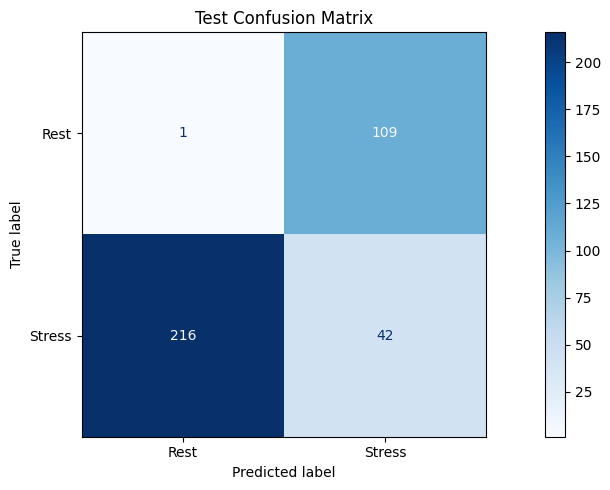

In [49]:
# Evaluate final model
loss, accuracy = final_model.evaluate(X_test, y_test)
print("Validation Accuracy:", accuracy)

# Evaluate the model on test data to get test predictions
y_test_pred = (final_model.predict(X_test) > 0.5).astype("int32")

# Confusion matrix for test data
test_cm = confusion_matrix(y_test, y_test_pred)
test_cmd = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=label_encoder.classes_)

# Plot confusion matrices
plt.figure(figsize=(12, 5))
test_cmd.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Test Confusion Matrix')

plt.tight_layout()
plt.show()